In [1]:
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint, sample_time):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.sample_time = sample_time

        self._last_error = 0.0
        self._integral = 0.0

    def update(self, current_value):
        error = self.setpoint - current_value
        self._integral += error * self.sample_time
        derivative = (error - self._last_error) / self.sample_time

        output = self.Kp * error + self.Ki * self._integral + self.Kd * derivative

        self._last_error = error

        return output


In [2]:
class HeatingSystem:
    def __init__(self, ambient_temp, heating_power, thermal_mass):
        self.ambient_temp = ambient_temp
        self.heating_power = heating_power
        self.thermal_mass = thermal_mass
        self.current_temp = ambient_temp

    def update(self, power_input, time_step):
        temp_change = power_input * self.heating_power / self.thermal_mass * time_step
        self.current_temp += temp_change
        return self.current_temp


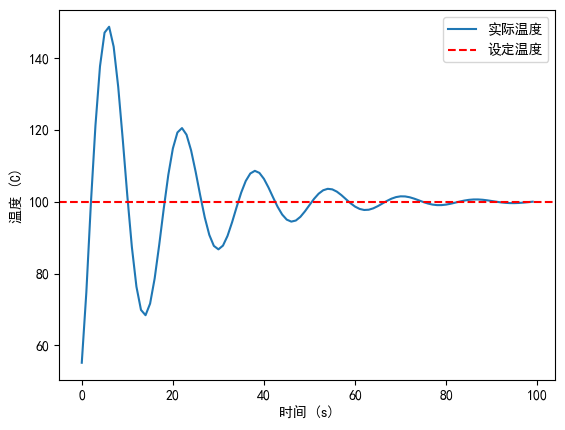

In [4]:
import matplotlib.pyplot as plt

# 仿真参数
setpoint = 100  # 目标温度
initial_temp = 20  # 初始温度
ambient_temp = 20  # 环境温度
heating_power = 100  # 加热功率
thermal_mass = 500  # 热容
sample_time = 1  # 采样时间
simulation_time = 100  # 仿真时间

# PID参数
Kp = 0.47
Ki = 0.86
Kd = 0.87

# 创建PID控制器和加热系统
pid = PID(Kp, Ki, Kd, setpoint, sample_time)
heating_system = HeatingSystem(ambient_temp, heating_power, thermal_mass)

# 存储仿真结果
times = []
temperatures = []

# 进行仿真
for t in range(0, simulation_time, sample_time):
    power_input = pid.update(heating_system.current_temp)
    current_temp = heating_system.update(power_input, sample_time)

    times.append(t)
    temperatures.append(current_temp)

# 绘制结果
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(times, temperatures, label="实际温度")
plt.axhline(y=setpoint, color='r', linestyle='--', label="设定温度")
plt.xlabel('时间 (s)')
plt.ylabel('温度 (C)')
plt.legend()
plt.savefig("PID_Simulator.png")
plt.show()


/var/folders/vk/0ylm12j90fn1c7c6pqg_zltw0000gn/T/ipykernel_75500/2426581539.py:13: RuntimeWarning: overflow encountered in scalar multiply
  temp_change = power_input * self.heating_power / self.thermal_mass * time_step
/var/folders/vk/0ylm12j90fn1c7c6pqg_zltw0000gn/T/ipykernel_75500/2426581539.py:14: RuntimeWarning: invalid value encountered in scalar add
  self.current_temp += temp_change


Best Kp: 6.463268352530881, Best Ki: 0.023415445146768965, Best Kd: 0.8240832026219459


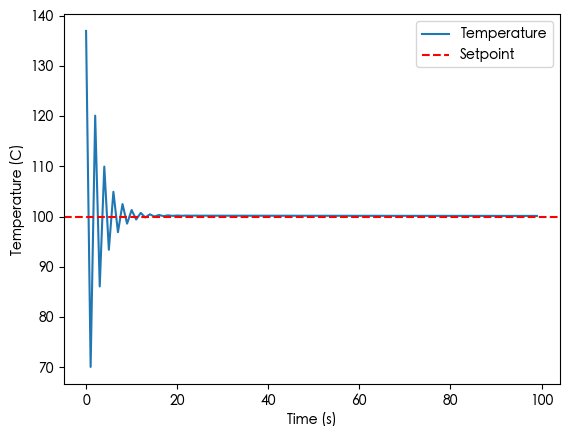

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 定义加热系统模型
class HeatingSystem:
    def __init__(self, ambient_temp, heating_power, thermal_mass):
        self.ambient_temp = ambient_temp
        self.heating_power = heating_power
        self.thermal_mass = thermal_mass
        self.current_temp = ambient_temp

    def update(self, power_input, time_step):
        temp_change = power_input * self.heating_power / self.thermal_mass * time_step
        self.current_temp += temp_change
        return self.current_temp

# 定义PID控制器类
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint, sample_time):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.sample_time = sample_time
        self._last_error = 0.0
        self._integral = 0.0

    def update(self, current_value):
        error = self.setpoint - current_value
        self._integral += error * self.sample_time
        derivative = (error - self._last_error) / self.sample_time
        output = self.Kp * error + self.Ki * self._integral + self.Kd * derivative
        self._last_error = error
        return output

# 定义适应度函数
def fitness_function(params, setpoint, heating_system, sample_time, simulation_time):
    Kp, Ki, Kd = params
    pid = PID(Kp, Ki, Kd, setpoint, sample_time)
    heating_system.current_temp = heating_system.ambient_temp

    error_sum = 0
    for t in range(0, simulation_time, sample_time):
        power_input = pid.update(heating_system.current_temp)
        current_temp = heating_system.update(power_input, sample_time)
        error = setpoint - current_temp

        # 限制误差值的范围，防止溢出
        error = np.clip(error, -1e6, 1e6)
        error_sum += error**2

    return -error_sum  # 返回负的误差平方和，因为我们希望最大化适应度

# 遗传算法参数
population_size = 20
generations = 50
mutation_rate = 0.1
crossover_rate = 0.7

# 初始化种群
population = np.random.rand(population_size, 3)  # 每个个体包含3个参数（Kp、Ki、Kd）

# 进行遗传算法
for generation in range(generations):
    fitness = []
    for individual in population:
        try:
            fitness_value = fitness_function(individual, setpoint=100, heating_system=HeatingSystem(20, 1000, 500), sample_time=1, simulation_time=500)
            if np.isnan(fitness_value):
                fitness_value = -np.inf
        except:
            fitness_value = -np.inf
        fitness.append(fitness_value)
    fitness = np.array(fitness)

    # 避免NaN和无穷值
    if np.any(np.isnan(fitness)) or np.any(np.isinf(fitness)):
        fitness[np.isnan(fitness) | np.isinf(fitness)] = -np.inf

    # 选择（轮盘赌选择）
    fitness_sum = np.sum(fitness)
    if fitness_sum == 0 or np.isinf(fitness_sum):
        probabilities = np.ones(population_size) / population_size
    else:
        probabilities = fitness / fitness_sum
    
    if np.any(np.isnan(probabilities)):
        probabilities = np.ones(population_size) / population_size

    selected_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
    selected_population = population[selected_indices]

    # 交叉
    next_population = []
    for i in range(0, population_size, 2):
        parent1, parent2 = selected_population[i], selected_population[i+1]
        if np.random.rand() < crossover_rate:
            crossover_point = np.random.randint(1, 3)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        else:
            child1, child2 = parent1, parent2
        next_population.extend([child1, child2])

    # 变异
    next_population = np.array(next_population)
    for individual in next_population:
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(0, 3)
            individual[mutation_point] = np.random.rand()

    population = next_population

# 找到最优参数
best_individual = population[np.argmax(fitness)]
best_Kp, best_Ki, best_Kd = best_individual
print(f"Best Kp: {best_Kp}, Best Ki: {best_Ki}, Best Kd: {best_Kd}")

# 使用最优参数进行仿真
pid = PID(best_Kp, best_Ki, best_Kd, setpoint=100, sample_time=1)
heating_system = HeatingSystem(20, 100, 500)
times = []
temperatures = []

for t in range(0, 100, 1):
    power_input = pid.update(heating_system.current_temp)
    current_temp = heating_system.update(power_input, 1)
    times.append(t)
    temperatures.append(current_temp)

# 绘制结果
plt.plot(times, temperatures, label="Temperature")
plt.axhline(y=100, color='r', linestyle='--', label="Setpoint")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

